In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this implementstion, we'll work using a timeseries dataset  recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany (http://www.bgc-jena.mpg.de/wetter/). <br>
In this dataset,  14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. <br>
Our goal by using this dataset is to feed a machine learning algorithm with air temperature data from the recent past in order to predict the air temperature 24 hours after.

# **Unzip the dataset**

In [2]:
!mkdir jena_climate
!cd jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-05-15 18:37:55--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.177.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.177.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.98MB/s    in 2.2s    

2022-05-15 18:37:58 (5.98 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os

fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
lines[2]

'01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60'

In [5]:
#Transform timesteps into numpy array
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [6]:
float_data[2]

array([ 9.96530e+02, -8.51000e+00,  2.64910e+02, -9.31000e+00,
        9.39000e+01,  3.21000e+00,  3.01000e+00,  2.00000e-01,
        1.88000e+00,  3.02000e+00,  1.31024e+03,  1.90000e-01,
        6.30000e-01,  1.71600e+02])

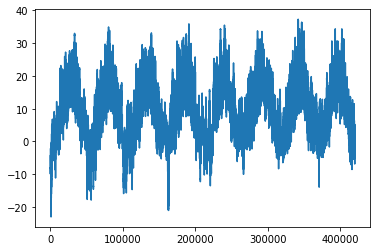

In [7]:
#Temperature recorded over the full temporal range of the dataset
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperatura (en grados Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

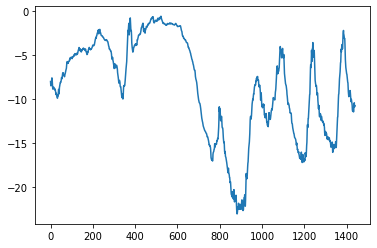

In [8]:
#Temperature over the first 10 days of the dataset
plt.plot(range(1440), temp[:1440])
plt.show()

# **Data preparation**

The exact formulation of the problem will be as follows: given data going as far back as *lookback* timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can you predict the temperature in delay timesteps? In order to address this problem, we’ll use the following parameter values:

lookback = 1440, observation will go back 5 days. <br>
steps = 6, observations will be sampled at one data point per hour. <br>
delay = 144, targets will be 24 hours in the future. <br>

**Dataset normalization**

In [9]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

**Build a data generator**

With the aim of extract the temporal data from the dataset and apply such data to train our model, it is recommended to desing a data generator. This generator will produce a tuple (*samples, targets*), where *samples* is an input batch of data and *targets* is an array that holds air temperature 24 hours after. T

In [10]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Now, we are going to use our generator to create three generators: one for the train set, another one for the validation set, and the last one for the test set. Each generator will take information from different time segments from the dataset: the train generator will use the first 200,000 timesteps, the validation generator will use the next 1000,000 timesteps, and finally, the test generator will extract the remaining timesteps.

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This variable will allow us to define how many times "validation_gen"  
# will be iterated to process the entire validation set.
val_steps = (300000 - 200001 - lookback) // batch_size

# This variable will allow us to define how many times "test_gen"  
# will be iterated to process the entire validation set.
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# **Recurrent neural network (GRU) architecture definition, compilation and training**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

es = EarlyStopping(monitor= 'val_loss', mode='min', patience = 10, verbose=1)
mc = ModelCheckpoint('/content/model_gru.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks = [es, mc])

Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 0.3070
Epoch 1: val_loss improved from inf to 0.27208, saving model to /content/model_gru.h5
500/500 [==============================] - 39s 65ms/step - loss: 0.3070 - val_loss: 0.2721
Epoch 2/20
499/500 [============================>.] - ETA: 0s - loss: 0.2835
Epoch 2: val_loss improved from 0.27208 to 0.27053, saving model to /content/model_gru.h5
500/500 [==============================] - 32s 65ms/step - loss: 0.2835 - val_loss: 0.2705
Epoch 3/20
499/500 [============================>.] - ETA: 0s - loss: 0.2742
Epoch 3: val_loss improved from 0.27053 to 0.26461, saving model to /content/model_gru.h5
500/500 [==============================] - 32s 64ms/step - loss: 0.2742 - val_loss: 0.2646
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 0.2682
Epoch 4: val_loss did not improve from 0.26461
500/500 [==============================] - 32s 64ms/step - loss: 0.2682 - val_loss: 0.2688
Epoch 5/20
500/

In [13]:
.2595 * std[1]

2.2972235118320987

# **Loss curves**

Best loss epoch :  3, Value :  0.2646123469


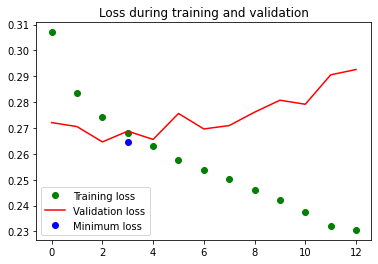

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(loss))

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Loss during training and validation')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()

# **Bidirectional Recurrent Neural Network**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

es = EarlyStopping(monitor= 'val_loss', mode='min', patience = 10, verbose=1)
mc = ModelCheckpoint('/content/model_gru6.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks = [es, mc])

Epoch 1/40
500/500 [==============================] - ETA: 0s - loss: 0.2957
Epoch 1: val_loss improved from inf to 0.26893, saving model to /content/model_gru6.h5
500/500 [==============================] - 72s 133ms/step - loss: 0.2957 - val_loss: 0.2689
Epoch 2/40
500/500 [==============================] - ETA: 0s - loss: 0.2750
Epoch 2: val_loss did not improve from 0.26893
500/500 [==============================] - 65s 130ms/step - loss: 0.2750 - val_loss: 0.2730
Epoch 3/40
500/500 [==============================] - ETA: 0s - loss: 0.2663
Epoch 3: val_loss improved from 0.26893 to 0.26483, saving model to /content/model_gru6.h5
500/500 [==============================] - 66s 132ms/step - loss: 0.2663 - val_loss: 0.2648
Epoch 4/40
500/500 [==============================] - ETA: 0s - loss: 0.2647
Epoch 4: val_loss did not improve from 0.26483
500/500 [==============================] - 65s 131ms/step - loss: 0.2647 - val_loss: 0.2663
Epoch 5/40
500/500 [==============================] 

# **Loss curves**

Best loss epoch :  5, Value :  0.2643731534


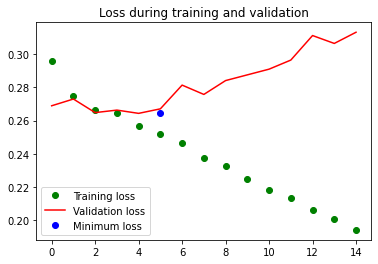

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(loss))

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Loss during training and validation')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()